In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

Data Preprocessing

In [2]:
# Step 1: Data Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Simulate lighting variations
    validation_split=0.15
)

# Load and combine default and real-world images
train_generator = train_datagen.flow_from_directory(
    'images/images/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    'images/images/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 12750 images belonging to 30 classes.
Found 2250 images belonging to 30 classes.


In [1]:
import os
os.listdir('images/images')

['aerosol_cans',
 'aluminum_food_cans',
 'aluminum_soda_cans',
 'cardboard_boxes',
 'cardboard_packaging',
 'clothing',
 'coffee_grounds',
 'disposable_plastic_cutlery',
 'eggshells',
 'food_waste',
 'glass_beverage_bottles',
 'glass_cosmetic_containers',
 'glass_food_jars',
 'magazines',
 'newspaper',
 'office_paper',
 'paper_cups',
 'plastic_cup_lids',
 'plastic_detergent_bottles',
 'plastic_food_containers',
 'plastic_shopping_bags',
 'plastic_soda_bottles',
 'plastic_straws',
 'plastic_trash_bags',
 'plastic_water_bottles',
 'shoes',
 'steel_food_cans',
 'styrofoam_cups',
 'styrofoam_food_containers',
 'tea_bags']

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'images/images/',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(224, 224),
  batch_size=32)

Found 15000 files belonging to 30 classes.
Using 12000 files for training.


In [6]:
class_names = train_ds.class_names
print(class_names)

['aerosol_cans', 'aluminum_food_cans', 'aluminum_soda_cans', 'cardboard_boxes', 'cardboard_packaging', 'clothing', 'coffee_grounds', 'disposable_plastic_cutlery', 'eggshells', 'food_waste', 'glass_beverage_bottles', 'glass_cosmetic_containers', 'glass_food_jars', 'magazines', 'newspaper', 'office_paper', 'paper_cups', 'plastic_cup_lids', 'plastic_detergent_bottles', 'plastic_food_containers', 'plastic_shopping_bags', 'plastic_soda_bottles', 'plastic_straws', 'plastic_trash_bags', 'plastic_water_bottles', 'shoes', 'steel_food_cans', 'styrofoam_cups', 'styrofoam_food_containers', 'tea_bags']


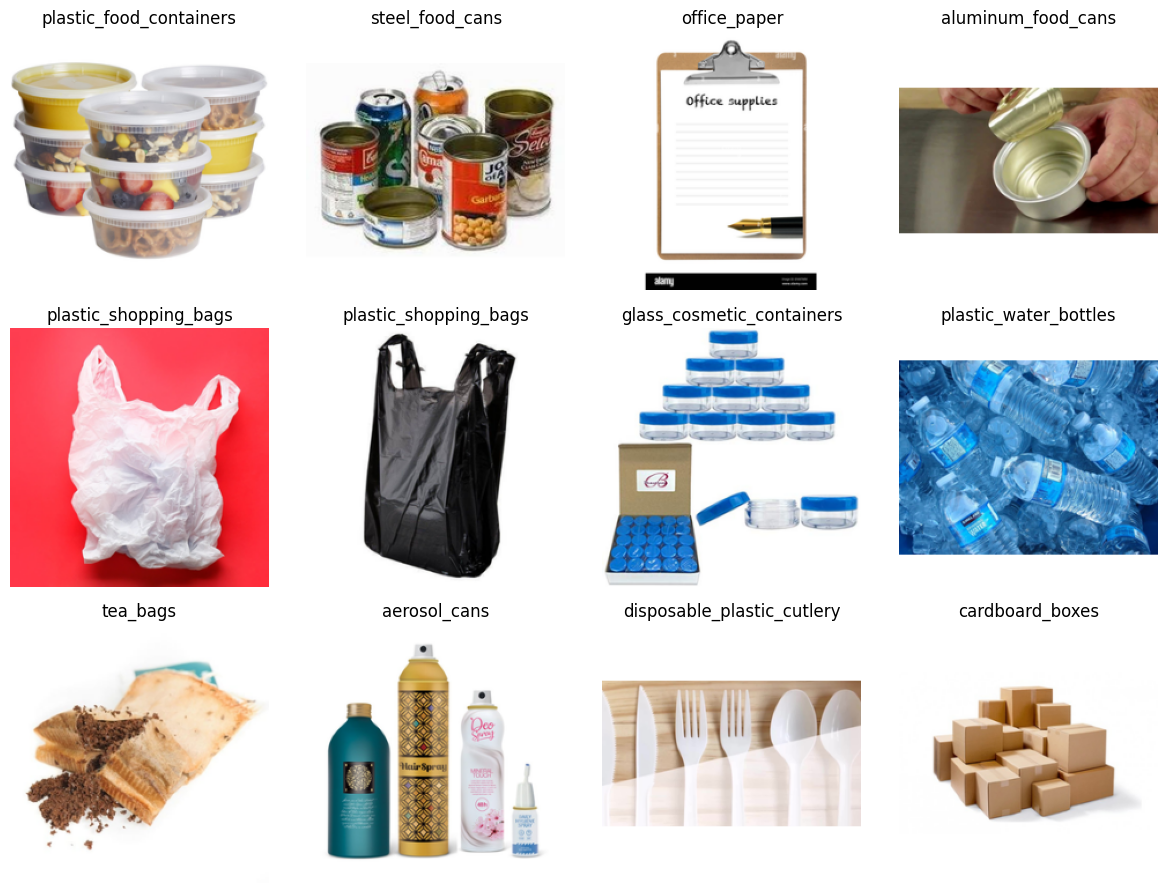

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        ax.grid(color='white', linestyle='-', linewidth=1.5)  # Add grid to each subplot
plt.tight_layout()  # Corrected function
plt.show()

Model Selection

In [15]:
# Step 2: Model Selection
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,600,478 (13.73 MB)

 Trainable params: 1,342,494 (5.12 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Training

In [4]:
# Step 3: Training
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, epochs=15, validation_data=val_generator)

d:\Waste_Classification\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 691s 2s/step - accuracy: 0.4272 - loss: 2.1510 - val_accuracy: 0.7151 - val_loss: 0.9270
Epoch 2/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 702s 2s/step - accuracy: 0.7165 - loss: 0.9556 - val_accuracy: 0.7684 - val_loss: 0.7628
Epoch 3/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 563s 1s/step - accuracy: 0.7644 - loss: 0.7838 - val_accuracy: 0.7911 - val_loss: 0.6725
Epoch 4/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 538s 1s/step - accuracy: 0.7847 - loss: 0.6974 - val_accuracy: 0.7982 - val_loss: 0.6470
Epoch 5/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 499s 1s/step - accuracy: 0.8005 - loss: 0.6439 - val_accuracy: 0.8080 - val_loss: 0.6160
Epoch 6/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 499s 1s/step - accuracy: 0.8219 - loss: 0.5802 - val_accuracy: 0.8040 - val_loss: 0.6068
Epoch 7/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 503s 1s/step - accuracy: 0.8199 - loss: 0.5588 - val_accuracy: 0.8058 - val_loss: 0.5626
Epoch 8/15
399/399 ━━━━━━━━━━━━━━━━━━━━ 505s 1s/step - accuracy: 0.8381 - loss: 0.5195 - val_accu

Evaluation

In [5]:
# Step 4: Evaluation
test_generator = train_datagen.flow_from_directory(
    'images/images/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

loss, accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Found 2250 images belonging to 30 classes.
71/71 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.8461 - loss: 0.4845
Test Accuracy: 83.60%


In [6]:
# Step 5: Save the Model
model.save('waste_classification_model_.h5')

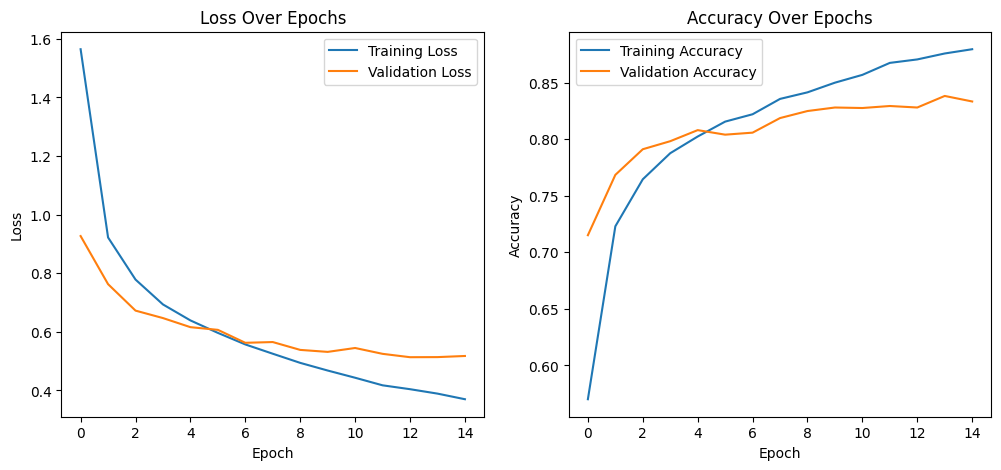

In [7]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


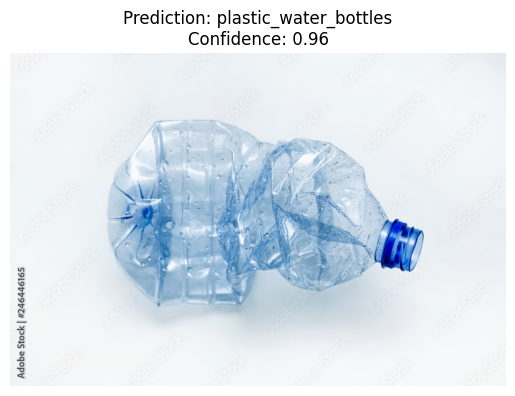

Predicted Category: plastic_water_bottles
Confidence: 0.96


In [4]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt

# Step 1: Load the Saved Model
model_path = 'models/waste_classification_model_.h5'  # Path to your saved model
model = tf.keras.models.load_model(model_path)

# Step 2: Define Class Labels
# Ensure these labels match the order of classes used during training
class_labels = ['aerosol_cans', 'aluminum_food_cans', 'aluminum_soda_cans', 
                'cardboard_boxes', 'cardboard_packaging', 'clothing', 
                'coffee_grounds', 'disposable_plastic_cutlery', 'eggshells', 
                'food_waste', 'glass_beverage_bottles', 'glass_cosmetic_containers', 
                'glass_food_jars', 'magazines', 'newspaper', 
                'office_paper', 'paper_cups', 'plastic_cup_lids', 
                'plastic_detergent_bottles', 'plastic_food_containers', 'plastic_shopping_bags', 
                'plastic_soda_bottles', 'plastic_straws', 'plastic_trash_bags', 
                'plastic_water_bottles', 'shoes', 'steel_food_cans', 
                'styrofoam_cups', 'styrofoam_food_containers', 'tea_bags']

# Step 3: Preprocess the Input Image
def preprocess_image(img_path, target_size=(224, 224)):
    """
    Load and preprocess an image for prediction.
    """
    img = image.load_img(img_path, target_size=target_size)  # Load and resize image
    img_array = image.img_to_array(img)  # Convert to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Preprocess for MobileNetV2
    return img_array

# Step 4: Predict the Category of an Image
def predict_image_category(img_path):
    """
    Predict the waste category of an image.
    """
    # Preprocess the image
    img_array = preprocess_image(img_path)

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_label = class_labels[predicted_class_index]
    confidence = np.max(predictions)

    # Display the image and prediction
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.title(f'Prediction: {predicted_class_label}\nConfidence: {confidence:.2f}')
    plt.axis('off')
    plt.show()

    return predicted_class_label, confidence

# Step 5: Test the Function
# Replace 'path_to_your_image.png' with the path to your test image
image_path = 'bottle.jpg'
predicted_label, confidence = predict_image_category(image_path)
print(f'Predicted Category: {predicted_label}')
print(f'Confidence: {confidence:.2f}')